モジュールのインポート 

In [2]:
from numpy import *
from pylab import *
import Optimizer_with_theano as op 
%matplotlib inline

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: TITAN X (Pascal) (CNMeM is disabled, cuDNN 5110)
/home/yu/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


yの時系列データをシーケンシャルに10個から、1時刻あとのデータ予測する学習器をつくる

# データの生成

In [100]:
def gen_dataset(v, length):
    v = v.flatten()
    idx = arange(v.size)
    idx = idx[:, None] + arange(length+1)
    idx = idx[:-length]
    xidx = idx[:, :-1]
    yidx = idx[:, -1]
    x_idx_f = xidx.flatten()
    y_idx_f = yidx.flatten()
    x = v[x_idx_f].reshape(-1, 1, 1, length)
    y = v[y_idx_f][:, None]
    return x, y, xidx, yidx

#v = zeros(1000)
#for i in range(10000):
#    v += sin(pi * arange(1000) / randint(10, 1000) + randint(0, 1000)) * arange(1000)[::-1]
v = sin(pi * arange(10000) / arange(1,10001)[::-1]*10) * arange(10000)[::-1]# + random(v.size) * arange(1000)[::-1] * 1
v = v[:-1000]
#v = sin(pi * arange(1000) / 30) * arange(1000)# + random(v.size) * arange(1000)[::-1] * 1
x, y, xidx, yidx = gen_dataset(v, 10)

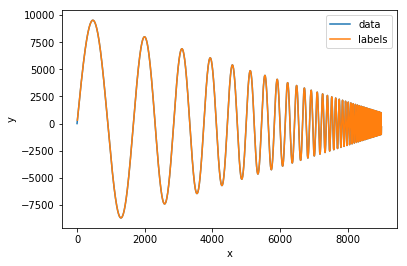

In [101]:
#plot(xidx.flatten(),x.flatten())
plot(arange(v.size),v)
plot(yidx.flatten(),y.flatten())
#xlim(8500,9500)
xlabel("x")
ylabel("y")
legend(["data", "labels"])

データ及びラベルの形は以下の通りである。

In [73]:
print("Shape of x = {}".format(x.shape))
print("Shape of y = {}".format(y.shape))

Shape of x = (8990, 1, 1, 10)
Shape of y = (8990, 1)


# 学習

## UCNNの構築

theanoは1次元の畳込みが無いので、2次元畳込みを用いる 

In [74]:

o = op.optimizer(n_batch=100)
o.set_data(x, y, test_size=0., is_shuffle=False)
o.set_variables()
o1 =  o.conv2d((1, 1, 1, 5), mode="same").relu()
o2 = o1.conv2d((1, 1, 1, 5), mode="same").relu()
o3 = o2.conv2d((1, 1, 1, 5), mode="same").relu()
o4 = o3.conv2d((1, 1, 1, 5), mode="same").relu()
o5 = o4.conv2d((1, 1, 1, 5), mode="same").relu() + o2 #前段の畳込み層をマージ
o6 = o5.conv2d((1, 1, 1, 5), mode="same").relu() + o1 #前段の畳込み層をマージ
o7 = o6.conv2d((1, 1, 1, 5), mode="same").relu()
o8 = o7.conv2d((1, 1, 1, 10), mode="valid")
o9 = o8.flatten()
o = o9.loss_mse()



(1, 1, 1)


In [133]:

o = op.optimizer(n_batch=1000)
o.set_data(x, y, test_size=0., is_shuffle=False)
o.set_variables()
o1  =  o.conv2d((1, 1, 1, 5), mode="same").relu()
o2  = o1.conv2d((1, 1, 1, 5), mode="same").relu()
o3  = o2.conv2d((1, 1, 1, 5), mode="same").relu()
o4  = o3.conv2d((1, 1, 1, 5), mode="same").relu()
o5  = o4.conv2d((1, 1, 1, 5), mode="same").relu() 
o6  = o5.conv2d((1, 1, 1, 5), mode="same").relu() 
o7  = o6.conv2d((1, 1, 1, 5), mode="same").relu() 
o8  = o7.conv2d((1, 1, 1, 5), mode="same").relu()  #前段の畳込み層をマージ
o9  = o8.conv2d((1, 1, 1, 5), mode="same").relu()  #前段の畳込み層をマージ
o10 = o9.conv2d((1, 1, 1, 5), mode="same").relu() 
o11 = o10.conv2d((1, 1, 1, 5), mode="same").relu() #+ o10
o12 = o11.conv2d((1, 1, 1, 5), mode="same").relu() #+ o9
o13 = o12.conv2d((1, 1, 1, 5), mode="same").relu() #+ o8
o14 = o13.conv2d((1, 1, 1, 5), mode="same").relu() #+ o7
o15 = o14.conv2d((1, 1, 1, 5), mode="same").relu() #+ o6
o16 = o15.conv2d((1, 1, 1, 5), mode="same").relu() #+ o5
o17 = o16.conv2d((1, 1, 1, 5), mode="same").relu() #+ o4
o18 = o17.conv2d((1, 1, 1, 5), mode="same").relu() + o3 #前段の畳込み層をマージ
o19 = o18.conv2d((1, 1, 1, 5), mode="same").relu() + o2 #前段の畳込み層をマージ
o20 = o19.conv2d((1, 1, 1, 5), mode="same").relu() 
o21 = o20.conv2d((1, 1, 1, 10), mode="valid")
o22 = o21.flatten()
o   = o22.loss_mse()



(1, 1, 1)


最適化手法を定義し、最適化させる。 

In [75]:
o = o.opt_Adam(0.01).compile()
o = o.optimize(10000000,10)

Epoch. 0: loss = 1.3329e+13, acc = 0.0000e+00, valid. loss = 2.1680e+09, valid. acc. = 0.0000e+00.
Epoch. 10: loss = 1.9755e+09, acc = 0.0000e+00, valid. loss = 1.9632e+09, valid. acc. = 0.0000e+00.
Epoch. 20: loss = 1.7249e+09, acc = 0.0000e+00, valid. loss = 1.7090e+09, valid. acc. = 0.0000e+00.
Epoch. 30: loss = 1.4232e+09, acc = 0.0000e+00, valid. loss = 1.4107e+09, valid. acc. = 0.0000e+00.
Epoch. 40: loss = 1.1059e+09, acc = 0.0000e+00, valid. loss = 1.0934e+09, valid. acc. = 0.0000e+00.
Epoch. 50: loss = 8.0249e+08, acc = 0.0000e+00, valid. loss = 7.9037e+08, valid. acc. = 0.0000e+00.
Epoch. 60: loss = 5.4441e+08, acc = 0.0000e+00, valid. loss = 5.3168e+08, valid. acc. = 0.0000e+00.
Epoch. 70: loss = 3.4149e+08, acc = 0.0000e+00, valid. loss = 3.3346e+08, valid. acc. = 0.0000e+00.
Epoch. 80: loss = 2.0150e+08, acc = 0.0000e+00, valid. loss = 1.9542e+08, valid. acc. = 0.0000e+00.
Epoch. 90: loss = 1.1096e+08, acc = 0.0000e+00, valid. loss = 1.0728e+08, valid. acc. = 0.0000e+00.
E

In [78]:
o = o.opt_Adam(0.001).compile()
o = o.optimize(10000000,10)


Epoch. 0: loss = 7.6931e+06, acc = 0.0000e+00, valid. loss = 7.6011e+06, valid. acc. = 0.0000e+00.
Epoch. 10: loss = 7.5505e+06, acc = 0.0000e+00, valid. loss = 7.5564e+06, valid. acc. = 0.0000e+00.
Epoch. 20: loss = 7.5804e+06, acc = 0.0000e+00, valid. loss = 7.5569e+06, valid. acc. = 0.0000e+00.
Epoch. 30: loss = 7.5723e+06, acc = 0.0000e+00, valid. loss = 7.5544e+06, valid. acc. = 0.0000e+00.
Epoch. 40: loss = 7.5742e+06, acc = 0.0000e+00, valid. loss = 7.5605e+06, valid. acc. = 0.0000e+00.
Epoch. 50: loss = 7.5750e+06, acc = 0.0000e+00, valid. loss = 7.5545e+06, valid. acc. = 0.0000e+00.
Epoch. 60: loss = 7.5361e+06, acc = 0.0000e+00, valid. loss = 7.5794e+06, valid. acc. = 0.0000e+00.
Epoch. 70: loss = 7.5924e+06, acc = 0.0000e+00, valid. loss = 7.5521e+06, valid. acc. = 0.0000e+00.
Epoch. 80: loss = 7.5152e+06, acc = 0.0000e+00, valid. loss = 7.5500e+06, valid. acc. = 0.0000e+00.
Epoch. 90: loss = 7.5521e+06, acc = 0.0000e+00, valid. loss = 7.5489e+06, valid. acc. = 0.0000e+00.
E

Epoch. 820: loss = 7.1872e+03, acc = 0.0000e+00, valid. loss = 5.5256e+03, valid. acc. = 0.0000e+00.
Epoch. 830: loss = 6.6027e+03, acc = 0.0000e+00, valid. loss = 5.3568e+03, valid. acc. = 0.0000e+00.
Epoch. 840: loss = 4.6449e+03, acc = 0.0000e+00, valid. loss = 5.2192e+03, valid. acc. = 0.0000e+00.
Epoch. 850: loss = 6.1653e+03, acc = 0.0000e+00, valid. loss = 4.0569e+03, valid. acc. = 0.0000e+00.
Epoch. 860: loss = 6.9121e+03, acc = 0.0000e+00, valid. loss = 7.0056e+03, valid. acc. = 0.0000e+00.
Epoch. 870: loss = 4.9153e+03, acc = 0.0000e+00, valid. loss = 5.2339e+03, valid. acc. = 0.0000e+00.
Epoch. 880: loss = 5.9092e+03, acc = 0.0000e+00, valid. loss = 6.8029e+03, valid. acc. = 0.0000e+00.
Epoch. 890: loss = 6.2219e+03, acc = 0.0000e+00, valid. loss = 4.3597e+03, valid. acc. = 0.0000e+00.
Epoch. 900: loss = 4.7723e+03, acc = 0.0000e+00, valid. loss = 3.6149e+03, valid. acc. = 0.0000e+00.
Epoch. 910: loss = 4.1455e+03, acc = 0.0000e+00, valid. loss = 3.3734e+03, valid. acc. = 0.

Epoch. 1630: loss = 5.1123e+03, acc = 0.0000e+00, valid. loss = 8.0484e+02, valid. acc. = 0.0000e+00.
Epoch. 1640: loss = 2.8741e+03, acc = 0.0000e+00, valid. loss = 8.2426e+02, valid. acc. = 0.0000e+00.
Epoch. 1650: loss = 2.4536e+03, acc = 0.0000e+00, valid. loss = 5.6117e+02, valid. acc. = 0.0000e+00.
Epoch. 1660: loss = 1.7384e+03, acc = 0.0000e+00, valid. loss = 2.9185e+03, valid. acc. = 0.0000e+00.
Epoch. 1670: loss = 1.4561e+03, acc = 0.0000e+00, valid. loss = 4.0058e+02, valid. acc. = 0.0000e+00.
Epoch. 1680: loss = 3.2006e+03, acc = 0.0000e+00, valid. loss = 6.2874e+03, valid. acc. = 0.0000e+00.
Epoch. 1690: loss = 2.0376e+03, acc = 0.0000e+00, valid. loss = 4.7898e+03, valid. acc. = 0.0000e+00.
Epoch. 1700: loss = 2.1372e+03, acc = 0.0000e+00, valid. loss = 2.1020e+03, valid. acc. = 0.0000e+00.
Epoch. 1710: loss = 1.6839e+03, acc = 0.0000e+00, valid. loss = 1.3037e+03, valid. acc. = 0.0000e+00.
Epoch. 1720: loss = 3.4456e+03, acc = 0.0000e+00, valid. loss = 2.2399e+03, valid.

Epoch. 2440: loss = 4.7868e+02, acc = 0.0000e+00, valid. loss = 4.5253e+02, valid. acc. = 0.0000e+00.
Epoch. 2450: loss = 2.4345e+02, acc = 0.0000e+00, valid. loss = 2.7442e+02, valid. acc. = 0.0000e+00.
Epoch. 2460: loss = 1.7517e+03, acc = 0.0000e+00, valid. loss = 2.2674e+03, valid. acc. = 0.0000e+00.
Epoch. 2470: loss = 1.7612e+03, acc = 0.0000e+00, valid. loss = 1.8586e+03, valid. acc. = 0.0000e+00.
Epoch. 2480: loss = 2.1401e+03, acc = 0.0000e+00, valid. loss = 8.8945e+02, valid. acc. = 0.0000e+00.
Epoch. 2490: loss = 1.8977e+03, acc = 0.0000e+00, valid. loss = 1.3558e+03, valid. acc. = 0.0000e+00.
Epoch. 2500: loss = 1.2705e+03, acc = 0.0000e+00, valid. loss = 1.2625e+03, valid. acc. = 0.0000e+00.
Epoch. 2510: loss = 8.5663e+02, acc = 0.0000e+00, valid. loss = 6.7339e+02, valid. acc. = 0.0000e+00.
Epoch. 2520: loss = 5.2509e+02, acc = 0.0000e+00, valid. loss = 1.9602e+02, valid. acc. = 0.0000e+00.
Epoch. 2530: loss = 2.7715e+02, acc = 0.0000e+00, valid. loss = 2.1842e+02, valid.

Epoch. 3250: loss = 1.2077e+03, acc = 0.0000e+00, valid. loss = 2.2022e+03, valid. acc. = 0.0000e+00.
Epoch. 3260: loss = 2.6606e+02, acc = 0.0000e+00, valid. loss = 3.5254e+02, valid. acc. = 0.0000e+00.
Epoch. 3270: loss = 5.3847e+02, acc = 0.0000e+00, valid. loss = 2.6810e+02, valid. acc. = 0.0000e+00.
Epoch. 3280: loss = 6.6476e+02, acc = 0.0000e+00, valid. loss = 4.6295e+02, valid. acc. = 0.0000e+00.
Epoch. 3290: loss = 1.6714e+03, acc = 0.0000e+00, valid. loss = 3.2385e+02, valid. acc. = 0.0000e+00.
Epoch. 3300: loss = 1.1762e+03, acc = 0.0000e+00, valid. loss = 8.2037e+02, valid. acc. = 0.0000e+00.
Epoch. 3310: loss = 1.2000e+03, acc = 0.0000e+00, valid. loss = 1.8289e+03, valid. acc. = 0.0000e+00.
Epoch. 3320: loss = 1.2889e+03, acc = 0.0000e+00, valid. loss = 1.7800e+03, valid. acc. = 0.0000e+00.
Epoch. 3330: loss = 1.3581e+03, acc = 0.0000e+00, valid. loss = 1.9218e+03, valid. acc. = 0.0000e+00.
Epoch. 3340: loss = 6.7752e+02, acc = 0.0000e+00, valid. loss = 2.5404e+02, valid.

Epoch. 4060: loss = 1.0783e+03, acc = 0.0000e+00, valid. loss = 1.2226e+03, valid. acc. = 0.0000e+00.
Epoch. 4070: loss = 6.8564e+02, acc = 0.0000e+00, valid. loss = 1.6207e+02, valid. acc. = 0.0000e+00.
Epoch. 4080: loss = 3.3394e+02, acc = 0.0000e+00, valid. loss = 5.6091e+02, valid. acc. = 0.0000e+00.
Epoch. 4090: loss = 3.0265e+02, acc = 0.0000e+00, valid. loss = 4.8105e+02, valid. acc. = 0.0000e+00.
Epoch. 4100: loss = 9.9039e+02, acc = 0.0000e+00, valid. loss = 1.2392e+03, valid. acc. = 0.0000e+00.
Epoch. 4110: loss = 2.3777e+03, acc = 0.0000e+00, valid. loss = 2.0712e+03, valid. acc. = 0.0000e+00.
Epoch. 4120: loss = 8.0157e+02, acc = 0.0000e+00, valid. loss = 1.4537e+03, valid. acc. = 0.0000e+00.
Epoch. 4130: loss = 3.0600e+02, acc = 0.0000e+00, valid. loss = 4.4502e+02, valid. acc. = 0.0000e+00.
Epoch. 4140: loss = 3.1296e+02, acc = 0.0000e+00, valid. loss = 1.8316e+02, valid. acc. = 0.0000e+00.
Epoch. 4150: loss = 6.0726e+02, acc = 0.0000e+00, valid. loss = 4.9546e+02, valid.

In [82]:

o = o.opt_Adam(0.000001).compile()
o = o.optimize(10000000,10)

Epoch. 0: loss = 8.5796e+01, acc = 0.0000e+00, valid. loss = 8.5983e+01, valid. acc. = 0.0000e+00.
Epoch. 10: loss = 8.5238e+01, acc = 1.1123e-04, valid. loss = 8.5892e+01, valid. acc. = 1.1123e-04.
Epoch. 20: loss = 8.5412e+01, acc = 0.0000e+00, valid. loss = 8.5888e+01, valid. acc. = 0.0000e+00.
Epoch. 30: loss = 8.6273e+01, acc = 0.0000e+00, valid. loss = 8.5877e+01, valid. acc. = 0.0000e+00.
Epoch. 40: loss = 8.5080e+01, acc = 1.1123e-04, valid. loss = 8.5871e+01, valid. acc. = 1.1123e-04.
Epoch. 50: loss = 8.6056e+01, acc = 1.1123e-04, valid. loss = 8.5864e+01, valid. acc. = 1.1123e-04.
Epoch. 60: loss = 8.6148e+01, acc = 1.1123e-04, valid. loss = 8.5873e+01, valid. acc. = 1.1123e-04.
Epoch. 70: loss = 8.6498e+01, acc = 0.0000e+00, valid. loss = 8.5848e+01, valid. acc. = 0.0000e+00.
Epoch. 80: loss = 8.6351e+01, acc = 0.0000e+00, valid. loss = 8.5842e+01, valid. acc. = 0.0000e+00.
Epoch. 90: loss = 8.6358e+01, acc = 1.1123e-04, valid. loss = 8.5847e+01, valid. acc. = 1.1123e-04.
E

Epoch. 820: loss = 8.5970e+01, acc = 3.3370e-04, valid. loss = 8.5394e+01, valid. acc. = 3.3370e-04.
Epoch. 830: loss = 8.5598e+01, acc = 0.0000e+00, valid. loss = 8.5390e+01, valid. acc. = 0.0000e+00.
Epoch. 840: loss = 8.5862e+01, acc = 1.1123e-04, valid. loss = 8.5393e+01, valid. acc. = 1.1123e-04.
Epoch. 850: loss = 8.5125e+01, acc = 0.0000e+00, valid. loss = 8.5376e+01, valid. acc. = 0.0000e+00.
Epoch. 860: loss = 8.4551e+01, acc = 0.0000e+00, valid. loss = 8.5368e+01, valid. acc. = 0.0000e+00.
Epoch. 870: loss = 8.4709e+01, acc = 1.1123e-04, valid. loss = 8.5362e+01, valid. acc. = 1.1123e-04.
Epoch. 880: loss = 8.5996e+01, acc = 0.0000e+00, valid. loss = 8.5357e+01, valid. acc. = 0.0000e+00.
Epoch. 890: loss = 8.5587e+01, acc = 0.0000e+00, valid. loss = 8.5349e+01, valid. acc. = 0.0000e+00.
Epoch. 900: loss = 8.5355e+01, acc = 1.1123e-04, valid. loss = 8.5343e+01, valid. acc. = 1.1123e-04.
Epoch. 910: loss = 8.5775e+01, acc = 0.0000e+00, valid. loss = 8.5343e+01, valid. acc. = 0.

Epoch. 1630: loss = 8.4941e+01, acc = 0.0000e+00, valid. loss = 8.4935e+01, valid. acc. = 0.0000e+00.
KeyboardInterrupt



In [ ]:
## 学習結果の評価

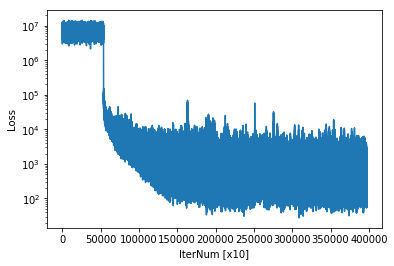

In [79]:
o.view()

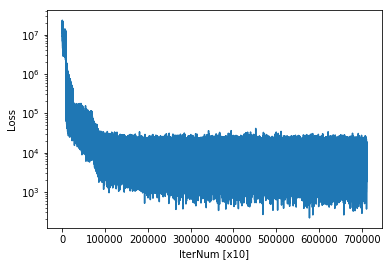

In [25]:
o.view()

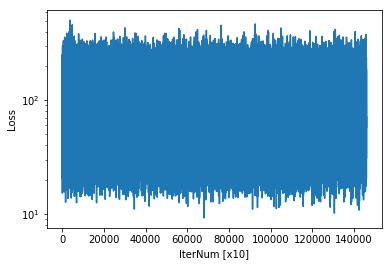

In [102]:
o.view()

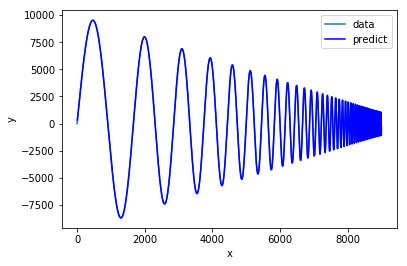

In [103]:
#plot(xidx.flatten(),x.flatten())
plot(arange(v.size),v)
#plot(yidx.flatten(),y.flatten())
plot(yidx, o.pred_func(x.reshape(-1, 1, 1, 10).astype(float32)).flatten(), c="b")
#xlim(0,100)
xlabel("x")
ylabel("y")
legend(["data", "predict"])
#xlim(8900, 9100)
#ylim(-100, 100)

(-2000, 2000)

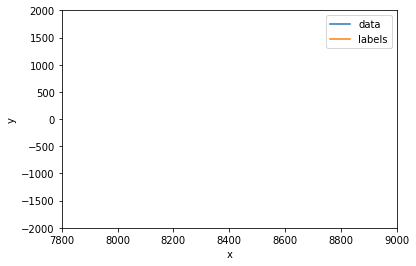

In [274]:
#plot(xidx.flatten(),x.flatten())
plot(arange(v.size),v)
plot(yidx.flatten(),y.flatten())
#plot(yidx, o.pred_func(x.reshape(-1, 1, 1, 10).astype(float32)).flatten(), c="b")
#xlim(0,100)
xlabel("x")
ylabel("y")
legend(["data", "labels"])
xlim(7800, 9000)
ylim(-2000, 2000)

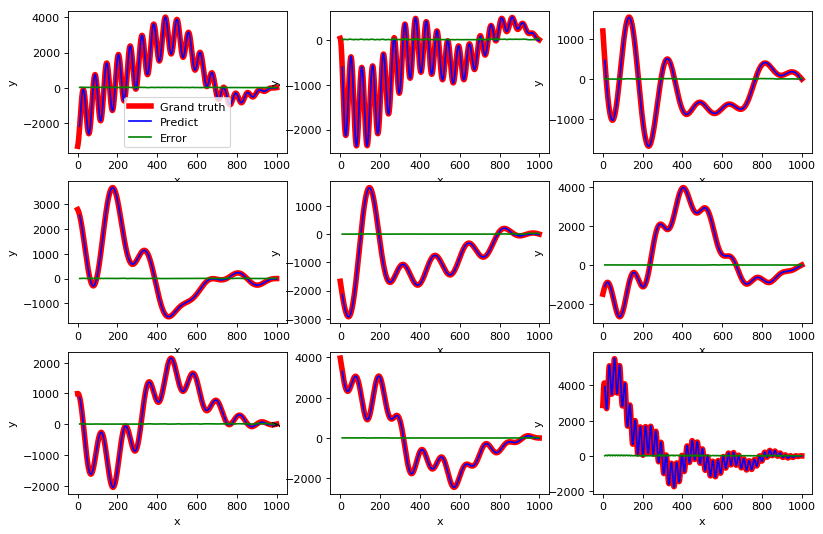

In [99]:
#figsize(10,10)
figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
is_first = True
for i in range(1,10,1):
    subplot(3, 3, i)
    v = zeros(1000)
    for i in range(10):
        #v += sin(pi * arange(1000) / 10) * arange(1000)[::-1]
        #v += sin(pi * arange(1000) / rand(1) / 100 + randint(0, 1000)) * arange(1000)[::-1]
        v += sin(pi * arange(1000) / randint(10, 1000) + randint(0, 1000)) * arange(1000)[::-1]
    #v2 = sin(pi * arange(1000) / 50) * arange(1000)[::-1]
    #v3 = cos(pi * arange(1000) / 250) * arange(1000)[::-1]
    #v = v + random(v.size)* arange(1000)[::-1] * 0.1
    #v = sin(pi * arange(1000) / 100) * arange(1000)[::-1] + random(v.size) * arange(1000)[::-1] * 1
    x, y, xidx, yidx = gen_dataset(v, 10) 
    #plot(xidx[0:100], x[0:100].reshape(-1,10), c="r")
    plot(arange(v.size),v, c="r",lw=5, label="Grand truth")
#plot(yidx.flatten(),y.flatten())
    plot(yidx, o.pred_func(x.reshape(-1, 1, 1, 10).astype(float32)).flatten(), c="b", label="Predict")
    plot(yidx, abs(y.flatten() - o.pred_func(x.reshape(-1, 1, 1, 10).astype(float32)).flatten()), c="g", label="Error")
    #xlim(0,300)
    
    #scatter(yidx[0:1000], o.y_train_arr[0:1000])
    xlabel("x")
    ylabel("y")
    if is_first:
        legend()
        is_first = False


In [166]:
line = loadtxt("/home/yu/Downloads/USDJPY.csv", delimiter=",")

適当な為替データ　http://www.m2j.co.jp/market/historical.php

In [170]:
line.shape

(2684, 4)

0
1
2
3


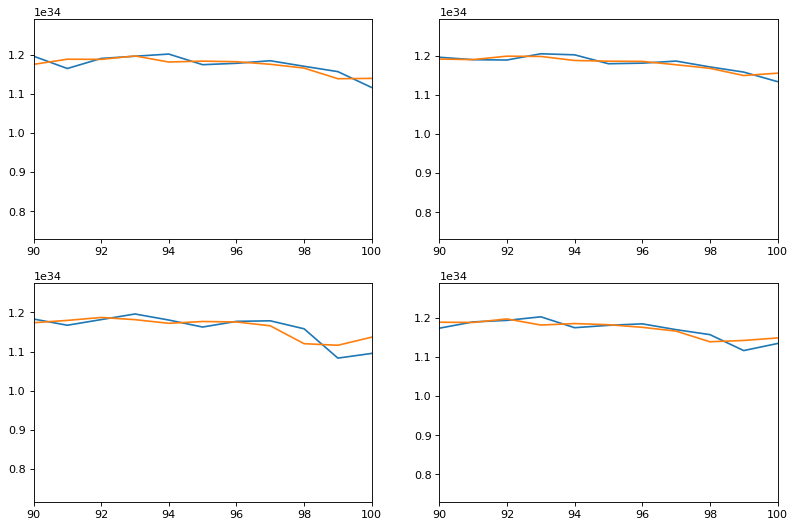

In [285]:
figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
for i,l in enumerate(line.T):
    l *= 100
    print(i)
    subplot(2, 2, i+1)
    x, y, xidx, yidx = gen_dataset(l, 10) 
    plot(yidx, o.pred_func(x.reshape(-1, 1, 1, 10).astype(float32)).flatten())
    plot(yidx, y.astype(float32).flatten())
    #plot(yidx, y - o.pred_func(x.reshape(-1, 1, 1, 10).astype(float32)).flatten())
    #plot(line[:,0])
    xlim(90,100)

In [ ]:

plot(arange(v.size),v, c="r",lw=5)
plot(yidx, o.pred_func(x.reshape(-1, 1, 1, 10).astype(float32)).flatten(), c="b")

In [479]:
line

array([[ 117.84,  118.08,  117.46,  117.84],
       [ 117.84,  118.98,  117.72,  118.96],
       [ 118.92,  119.08,  118.56,  118.72],
       ..., 
       [ 111.84,  112.14,  111.07,  111.14],
       [ 111.14,  111.67,  110.78,  111.27],
       [ 111.26,  111.31,  110.55,  110.66]])

In [478]:
xidx

array([[    0,     1,     2, ...,     7,     8,     9],
       [    1,     2,     3, ...,     8,     9,    10],
       [    2,     3,     4, ...,     9,    10,    11],
       ..., 
       [10723, 10724, 10725, ..., 10730, 10731, 10732],
       [10724, 10725, 10726, ..., 10731, 10732, 10733],
       [10725, 10726, 10727, ..., 10732, 10733, 10734]])

In [120]:
[x.shape.eval() for x in lst]

[array([1, 2, 4]), array([1, 2, 4]), array([1, 2, 4])]

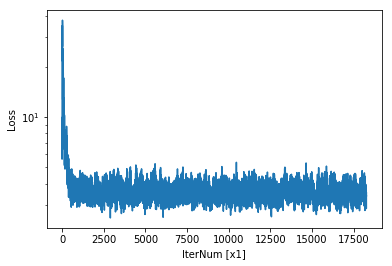

In [3]:
o.view()

In [1]:
import Optimizer as op
o = op.optimizer(n_batch=10)
o = o.set_datasets("mnist", is_one_hot=True)
o.x_train_arr /= 255
#o.set_data(x, y, test_size=0., is_shuffle=False)
o.set_variables()
o = o.dense(10)
o = o.softmax().loss_cross_entropy()
o = o.opt_Adam(0.01).compile()
o = o.optimize(10000,1)

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: TITAN X (Pascal) (CNMeM is disabled, cuDNN 5110)
/home/yu/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


784 10
Epoch. 0: loss = 2.8763e+00, acc = 1.2275e-01, valid. loss = 2.7400e+00, valid. acc. = 1.2275e-01.
Epoch. 1: loss = 2.7319e+00, acc = 1.2744e-01, valid. loss = 2.7036e+00, valid. acc. = 1.2744e-01.
KeyboardInterrupt



In [4]:
o = o.opt_Adam(0.1).compile()
o = o.optimize(10000,1)


Epoch. 0: loss = 1.5887e+01, acc = 5.1143e-02, valid. loss = 1.5823e+01, valid. acc. = 5.1143e-02.
Epoch. 1: loss = 1.5810e+01, acc = 1.0957e-01, valid. loss = 1.5884e+01, valid. acc. = 1.0957e-01.
Epoch. 2: loss = 1.5840e+01, acc = 1.1337e-01, valid. loss = 1.5900e+01, valid. acc. = 1.1337e-01.
Epoch. 3: loss = 1.5856e+01, acc = 1.1506e-01, valid. loss = 1.5874e+01, valid. acc. = 1.1506e-01.
Epoch. 4: loss = 1.5845e+01, acc = 1.1719e-01, valid. loss = 1.5754e+01, valid. acc. = 1.1719e-01.
Epoch. 5: loss = 1.5818e+01, acc = 1.1659e-01, valid. loss = 1.5818e+01, valid. acc. = 1.1659e-01.
Epoch. 6: loss = 1.5821e+01, acc = 1.1737e-01, valid. loss = 1.5833e+01, valid. acc. = 1.1737e-01.
Epoch. 7: loss = 1.5840e+01, acc = 1.1776e-01, valid. loss = 1.5765e+01, valid. acc. = 1.1776e-01.
Epoch. 8: loss = 1.5855e+01, acc = 1.1740e-01, valid. loss = 1.5842e+01, valid. acc. = 1.1740e-01.
Epoch. 9: loss = 1.5825e+01, acc = 1.1960e-01, valid. loss = 1.5766e+01, valid. acc. = 1.1960e-01.
Epoch. 10:

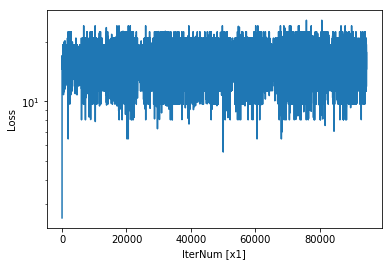

In [5]:
o.view()

In [ ]:
import Optimizer as op
o = op.optimizer(n_batch=100)
o = o.set_datasets("mnist", is_one_hot=True)
o.x_train_arr /= 255
#o.set_data(x, y, test_size=0., is_shuffle=False)
o.set_variables()
o = o.dense(10)
o = o.softmax().loss_cross_entropy()
o = o.opt_Adam(0.01).compile()
o = o.optimize(10000,1)

784 10
Epoch. 0: loss = 3.1429e+00, acc = 1.1556e-01, valid. loss = 2.7142e+00, valid. acc. = 1.1556e-01.
Epoch. 1: loss = 2.6899e+00, acc = 1.2122e-01, valid. loss = 2.6732e+00, valid. acc. = 1.2122e-01.
Epoch. 2: loss = 2.6645e+00, acc = 1.2395e-01, valid. loss = 2.6327e+00, valid. acc. = 1.2395e-01.
Epoch. 3: loss = 2.6405e+00, acc = 1.2440e-01, valid. loss = 2.6472e+00, valid. acc. = 1.2440e-01.
Epoch. 4: loss = 2.6399e+00, acc = 1.2663e-01, valid. loss = 2.6163e+00, valid. acc. = 1.2663e-01.
Epoch. 5: loss = 2.6173e+00, acc = 1.3210e-01, valid. loss = 2.6131e+00, valid. acc. = 1.3210e-01.
Epoch. 6: loss = 2.6092e+00, acc = 1.0997e-01, valid. loss = 2.5752e+00, valid. acc. = 1.0997e-01.
Epoch. 7: loss = 2.6125e+00, acc = 1.3656e-01, valid. loss = 2.5740e+00, valid. acc. = 1.3656e-01.
Epoch. 8: loss = 2.6077e+00, acc = 1.3070e-01, valid. loss = 2.6117e+00, valid. acc. = 1.3070e-01.
Epoch. 9: loss = 2.6084e+00, acc = 1.2997e-01, valid. loss = 2.5772e+00, valid. acc. = 1.2997e-01.
Epo

In [5]:
import Optimizer as op
o = op.optimizer(n_batch=100)
o = o.set_datasets("mnist", is_one_hot=True)
o.x_train_arr /= 255
#o.set_data(x, y, test_size=0., is_shuffle=False)
o.set_variables()
o = o.dense(10)
o = o.softmax().loss_cross_entropy()
o = o.opt_Adam(0.01).compile()
o = o.optimize(10000,1)

UnusedInputError: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 0 is not part of the computational graph needed to compute the outputs: InplaceDimShuffle{0,x}.0.
To make this error into a warning, you can pass the parameter on_unused_input='warn' to theano.function. To disable it completely, use on_unused_input='ignore'.

In [3]:
import Optimizer as op
o = op.optimizer(n_batch=10)
o = o.set_datasets("mnist", is_one_hot=True)
#o.x_train_arr /= 255
#o.set_data(x, y, test_size=0., is_shuffle=False)
o = o.dense(10).rnn(0)
o = o.softmax().loss_cross_entropy()
o = o.opt_Adam(0.001).compile()
o = o.optimize(10000,1)

784 10
Epoch. 0: loss = 1.8420e+00, acc = 3.1746e-05, valid. loss = 1.8420e+00, valid. acc. = 3.1746e-05.
Epoch. 1: loss = 1.8420e+00, acc = 3.1746e-05, valid. loss = 1.8420e+00, valid. acc. = 3.1746e-05.
KeyboardInterrupt



In [2]:
import Optimizer as op
o = op.optimizer(n_batch=100)
o = o.set_datasets("mnist", is_one_hot=True)
o.x_train_arr /= 255
#o.set_data(x, y, test_size=0., is_shuffle=False)
o = o.dense(10)
o = o.softmax().loss_cross_entropy()

o = o.opt_Adam(0.01).compile()
o = o.optimize(10000,1)

784 10
Epoch. 0: loss = 3.1475e+02, acc = 1.0306e-01, valid. loss = 1.6947e+05, valid. acc. = 1.0306e-01.
Epoch. 1: loss = 2.7024e+02, acc = 1.2046e-01, valid. loss = 1.6682e+05, valid. acc. = 1.2046e-01.
Epoch. 2: loss = 2.6628e+02, acc = 1.1483e-01, valid. loss = 1.6579e+05, valid. acc. = 1.1483e-01.
Epoch. 3: loss = 2.6474e+02, acc = 1.2743e-01, valid. loss = 1.6457e+05, valid. acc. = 1.2743e-01.
Epoch. 4: loss = 2.6408e+02, acc = 1.2879e-01, valid. loss = 1.6398e+05, valid. acc. = 1.2879e-01.
Epoch. 5: loss = 2.6265e+02, acc = 1.2324e-01, valid. loss = 1.6289e+05, valid. acc. = 1.2324e-01.
Epoch. 6: loss = 2.6120e+02, acc = 1.2595e-01, valid. loss = 1.6439e+05, valid. acc. = 1.2595e-01.
Epoch. 7: loss = 2.6097e+02, acc = 1.3159e-01, valid. loss = 1.6214e+05, valid. acc. = 1.3159e-01.
Epoch. 8: loss = 2.6074e+02, acc = 1.3429e-01, valid. loss = 1.6251e+05, valid. acc. = 1.3429e-01.
Epoch. 9: loss = 2.6117e+02, acc = 1.2968e-01, valid. loss = 1.6294e+05, valid. acc. = 1.2968e-01.
Epo

In [3]:
o.params

[<CudaNdarrayType(float32, matrix)>, <CudaNdarrayType(float32, vector)>]

In [6]:
o.loss.eval({o.x:o.x_train_arr, o.ylst[0]:o.y_train_arr}).shape

(63000,)

In [ ]:

o = o.opt_Adam(0.001).compile()
o = o.optimize(10000,10)


Epoch. 0: loss = 2.5560e+00, acc = 1.2833e-01, valid. loss = 2.5419e+00, valid. acc. = 1.2833e-01.
Epoch. 10: loss = 2.5403e+00, acc = 1.3190e-01, valid. loss = 2.5361e+00, valid. acc. = 1.3190e-01.
Epoch. 20: loss = 2.5371e+00, acc = 1.4356e-01, valid. loss = 2.5322e+00, valid. acc. = 1.4356e-01.
Epoch. 30: loss = 2.5343e+00, acc = 1.4363e-01, valid. loss = 2.5308e+00, valid. acc. = 1.4363e-01.
Epoch. 40: loss = 2.5323e+00, acc = 1.4032e-01, valid. loss = 2.5278e+00, valid. acc. = 1.4032e-01.
Epoch. 50: loss = 2.5310e+00, acc = 1.4998e-01, valid. loss = 2.5259e+00, valid. acc. = 1.4998e-01.
Epoch. 60: loss = 2.5290e+00, acc = 1.4594e-01, valid. loss = 2.5245e+00, valid. acc. = 1.4594e-01.
Epoch. 70: loss = 2.5281e+00, acc = 1.4351e-01, valid. loss = 2.5237e+00, valid. acc. = 1.4351e-01.
Epoch. 80: loss = 2.5266e+00, acc = 1.5308e-01, valid. loss = 2.5247e+00, valid. acc. = 1.5308e-01.
Epoch. 90: loss = 2.5264e+00, acc = 1.4925e-01, valid. loss = 2.5209e+00, valid. acc. = 1.4925e-01.
E

In [4]:
concatenate([array([9]),array([2,3,4])])

array([9, 2, 3, 4])

In [5]:
ones((3,3,3))[...,None].shape

(3, 3, 3, 1)

In [161]:
import theano as th
from numpy import *
import numpy as np
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original', data_home="data_dir_for_optimizer")

x_arr = mnist["data"]
y_arr = mnist["target"]

size = x_arr.shape[0]

x = th.tensor.dmatrix("x").astype(th.config.floatX)
y = th.tensor.dmatrix("y").astype("int32")

W = th.shared(random.rand(784,10).astype(dtype=th.config.floatX), borrow=True)
b = th.shared(random.rand(10).astype(dtype=th.config.floatX), borrow=True)

out = th.tensor.nnet.softmax(x.dot(W) + b)
#loss = -th.tensor.mean(y * th.tensor.log(out + 1e-4))
loss = -th.tensor.mean(th.tensor.log(out + 1e-4)[th.tensor.arange(y.shape[0]), y.flatten()]).astype(th.config.floatX)

idx = th.shared(0).astype(dtype="int32")

x_arr = th.shared(x_arr.astype(dtype=th.config.floatX))
y_arr = th.shared(y_arr.astype(dtype="int32"))

f = th.function(inputs=[idx],
                outputs=loss,
                on_unused_input='ignore',
                updates=[(W, W - 0.0001 * th.grad(loss, W)),
                         (b, b - 0.0001 * th.grad(loss, b))],
                givens=[(x, x_arr[idx:idx+100]), (y, y_arr[idx:idx+100, None])])

for i in range(100):
    for j in range(0, size-100, 100):
        loss = f(j)
    print(loss)


3.4998669624328613
2.970357656478882
2.5788233280181885
2.3907742500305176
2.0066370964050293
2.117086410522461
2.026233434677124
2.0261969566345215
1.9340922832489014
1.473728895187378
1.381466031074524
1.4735664129257202
1.381466031074524
1.4735510349273682
1.4450583457946777
1.5514671802520752
1.5122466087341309
1.5107382535934448
1.4340012073516846
1.2350505590438843
1.289361596107483


KeyboardInterrupt: 

In [160]:
import theano as th
from numpy import *
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original', data_home="data_dir_for_optimizer")

x_arr = mnist["data"]

idx = mnist["target"]
arr = zeros((idx.shape[0],10)).flatten()
arr[idx.flatten().astype(int) + arange(idx.shape[0]) * int(idx.max())]  = 1
arr = arr.reshape(idx.size, 10)
y_arr = arr

size = x_arr.shape[0]

x = th.tensor.dmatrix("x").astype(th.config.floatX)
y = th.tensor.dmatrix("y").astype("int32")

W = th.shared(random.rand(784,10).astype(dtype=th.config.floatX), borrow=True)
b = th.shared(random.rand(10).astype(dtype=th.config.floatX), borrow=True)

out = th.tensor.nnet.softmax(x.dot(W) + b)
loss = -th.tensor.mean(out * th.tensor.log(y + 1e-4))

idx = th.shared(0).astype(dtype="int32")

x_arr = th.shared(x_arr.astype(dtype=th.config.floatX))
y_arr = th.shared(y_arr.astype(dtype="int32"))


f = th.function(inputs=[idx],
                outputs=loss,
                on_unused_input='ignore',
                updates=[(W, W - 0.0001 * th.grad(loss, W)),
                         (b, b - 0.0001 * th.grad(loss, b))],
                givens=[(x, x_arr[idx:idx+100]), (y, y_arr[idx:idx+100])])

for i in range(100):
    for j in range(0, size-100, 100):
        loss = f(j)
    print(loss)


0.9210340387405115
0.9210340400696587
0.9210340395120877
0.9210340392042159
0.9210340394320792
0.9210340403567177
0.9210340386768939
0.9210340387548388
0.9210340393186343
0.9210340400540475
0.9210340393799111
0.9210340389116061
0.9210340402111538
0.9210340400905459
0.9210340405027893
0.9210340398349144
0.9210340407418887
0.9210340394700124
0.9210340398961314
0.9210340394202108
0.9210340400496093
0.9210340404426638
0.9210340395498834
0.9210340405687344
0.9210340394063872
0.9210340396210892
0.9210340400204202
0.9210340395907475
0.9210340402661812
0.9210340401911186
0.9210340392120967
0.9210340403328408
0.9210340401197342
0.9210340398219474
0.9210340400917347
0.9210340395345196
0.9210340399319531
0.9210340394835139
0.9210340390054258
0.9210340391962492
0.9210340397412345
0.9210340390687641
0.9210340393250112
0.9210340394406795
0.9210340389548163
0.9210340394425083
0.9210340402059989
0.9210340388663774
0.9210340393138943
0.9210340402732295
0.9210340405212823
0.9210340395522636
0.9210340396

In [139]:
arr

array([[ 1.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [135]:

idx = mnist["target"]
arr = np.zeros((idx.shape[0],10)).flatten()

In [136]:
arr

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [113]:
th.tensor.log(out).eval({x:x_arr[0:100].eval()})[arange(100),ones(100).astype("int32")]
#loss.eval({x:x_arr[0:100].eval(),y:y_arr[0:100].eval()})

array([-1222.06933594, -1691.1953125 , -2301.65234375, -2041.9921875 ,
       -1278.26367188, -1093.96484375, -2062.72070312,  -267.88867188,
       -1697.140625  , -1134.84179688, -1529.87304688,   -43.39648438,
       -1202.33007812, -1201.87988281, -1426.65625   , -1001.68945312,
       -1550.94726562,  -836.39257812, -1343.17871094, -1242.71484375,
       -1657.64355469,  -356.46679688,  -868.3515625 ,  -876.57226562,
       -1750.71386719,  -770.76757812, -1041.54101562, -1465.82617188,
        -385.72558594,  -973.76367188, -1031.45214844,  -926.58007812,
       -1352.60546875,  -428.49804688, -1483.50976562, -1331.0546875 ,
       -1033.375     , -1653.61132812, -1459.44140625, -1223.55664062,
        -727.69726562, -1366.359375  ,  -506.24609375, -1457.72460938,
       -1464.46972656,  -645.3125    , -1114.484375  , -1233.140625  ,
       -1710.96582031, -1698.69433594, -1693.796875  ,   -46.41308594,
        -491.13085938, -1510.20507812, -1936.21875   , -1575.91796875,
      

In [120]:
y.sha

Elemwise{Cast{int32}}.0

In [115]:
ones(10).dtype

dtype('float64')

In [67]:
th.tensor.log(y + 1e-4).eval({y:y_arr.eval()}).shape

(70000, 10)

In [77]:
loss.eval({x:x_arr.eval(),y:y_arr.eval()})

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (100,) (70000,) 
Apply node that caused the error: AdvancedSubtensor(HostFromGpu.0, TensorConstant{[ 0  1  2 .. 97 98 99]}, argmax)
Toposort index: 9
Inputs types: [TensorType(float32, matrix), TensorType(int64, vector), TensorType(int64, vector)]
Inputs shapes: [(70000, 10), (100,), (70000,)]
Inputs strides: [(40, 4), (8,), (8,)]
Inputs values: ['not shown', 'not shown', 'not shown']
Inputs type_num: [11, 7, 7]
Outputs clients: [[Sum{acc_dtype=float64}(AdvancedSubtensor.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/home/yu/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/yu/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/yu/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/yu/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/yu/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2683, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/yu/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2787, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/yu/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2847, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-75-4509fea945d3>", line 27, in <module>
    loss = -th.tensor.mean(th.tensor.log(y + 1e-4)[th.tensor.arange(100), out.argmax(axis=1)]).astype(th.config.floatX)

Debugprint of the apply node: 
AdvancedSubtensor [id A] <TensorType(float32, vector)> ''   
 |HostFromGpu [id B] <TensorType(float32, matrix)> ''   
 | |GpuElemwise{Composite{log((i0 + i1))}}[(0, 1)] [id C] <CudaNdarrayType(float32, matrix)> ''   
 |   |CudaNdarrayConstant{[[  9.99999975e-05]]} [id D] <CudaNdarrayType(float32, (True, True))>
 |   |GpuFromHost [id E] <CudaNdarrayType(float32, matrix)> ''   
 |     |<TensorType(float32, matrix)> [id F] <TensorType(float32, matrix)>
 |TensorConstant{[ 0  1  2 .. 97 98 99]} [id G] <TensorType(int64, vector)>
 |Argmax [id H] <TensorType(int64, vector)> 'argmax'   

Storage map footprint:
 - <TensorType(float32, matrix)>, Input, Shape: (70000, 784), ElemSize: 4 Byte(s), TotalSize: 219520000 Byte(s)
 - GpuFromHost.0, Shape: (70000, 784), ElemSize: 4 Byte(s), TotalSize: 219520000 Byte(s)
 - HostFromGpu.0, Shape: (70000, 10), ElemSize: 4 Byte(s), TotalSize: 2800000 Byte(s)
 - GpuFromHost.0, Shape: (70000, 10), ElemSize: 4 Byte(s), TotalSize: 2800000 Byte(s)
 - GpuDot22.0, Shape: (70000, 10), ElemSize: 4 Byte(s), TotalSize: 2800000 Byte(s)
 - GpuElemwise{Add}[(0, 0)].0, Shape: (70000, 10), ElemSize: 4 Byte(s), TotalSize: 2800000 Byte(s)
 - <TensorType(float32, matrix)>, Input, Shape: (70000, 10), ElemSize: 4 Byte(s), TotalSize: 2800000 Byte(s)
 - GpuElemwise{Composite{log((i0 + i1))}}[(0, 1)].0, Shape: (70000, 10), ElemSize: 4 Byte(s), TotalSize: 2800000 Byte(s)
 - HostFromGpu.0, Shape: (70000, 10), ElemSize: 4 Byte(s), TotalSize: 2800000 Byte(s)
 - argmax, Shape: (70000,), ElemSize: 8 Byte(s), TotalSize: 560000 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (784, 10), ElemSize: 4 Byte(s), TotalSize: 31360 Byte(s)
 - TensorConstant{[ 0  1  2 .. 97 98 99]}, Shape: (100,), ElemSize: 8 Byte(s), TotalSize: 800 Byte(s)
 - AdvancedSubtensor.0, Shape: (100,), ElemSize: 4 Byte(s), TotalSize: 400 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (10,), ElemSize: 4 Byte(s), TotalSize: 40 Byte(s)
 - GpuDimShuffle{x,0}.0, Shape: (1, 10), ElemSize: 4 Byte(s), TotalSize: 40 Byte(s)
 - TensorConstant{(1,) of 1}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{-0.0099999..9776482582}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - CudaNdarrayConstant{[[  9.99999975e-05]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 TotalSize: 453632616.0 Byte(s) 0.422 GB
 TotalSize inputs: 222352216.0 Byte(s) 0.207 GB



In [94]:
arange(3).dtype

dtype('int64')

In [97]:
y.eval({y:arange(10).astype("int32")[:,None]})

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]], dtype=int32)

In [92]:
y.eval({y:arange(10)})

TypeError: Bad input argument to theano function with name "<ipython-input-90-e1fcf0a87b4f>:1" at index 0 (0-based).  
Backtrace when that variable is created:

  File "/home/yu/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/yu/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/yu/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/yu/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/yu/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2683, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/yu/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2787, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/yu/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2847, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-89-72a403c26aaf>", line 19, in <module>
    y = th.tensor.dmatrix("y").astype("int32")
TensorType(int32, matrix) cannot store a value of dtype int64 without risking loss of precision. If you do not mind this loss, you can: 1) explicitly cast your data to int32, or 2) set "allow_input_downcast=True" when calling "function". Value: "array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])"

In [90]:
y.eval({y:y_arr.eval()})

TypeError: Bad input argument to theano function with name "<ipython-input-90-e1fcf0a87b4f>:1" at index 0 (0-based).  
Backtrace when that variable is created:

  File "/home/yu/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/yu/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/yu/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/yu/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/yu/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2683, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/yu/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2787, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/yu/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2847, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-89-72a403c26aaf>", line 19, in <module>
    y = th.tensor.dmatrix("y").astype("int32")
CudaNdarray support only support float32 dtype, provided: 5

In [78]:
loss.eval({x:x_arr[0:100].eval(),y:y_arr.eval()})

array(8.012983322143555, dtype=float32)

In [79]:
loss.eval({x:x_arr[0:100].eval(),y:y_arr[0:100].eval()})

array(8.012983322143555, dtype=float32)

In [68]:
out.argmax(axis=1).eval({x:x_arr.eval()}).tpp

array([3, 3, 1, ..., 7, 3, 1])

In [69]:
out.argmax(axis=1).eval({x:x_arr.eval()}).dtype

dtype('int64')

In [62]:
out.argmax(axis=1).eval({x:x_arr.eval()}).shape

(70000,)

In [57]:
out.

Softmax.0

In [80]:
eye(10)[arange(10),array([0,1,2,3,4,5,6,7,8])]

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (10,) (9,) 

In [63]:
eye(10)

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [49]:
f(0)


array(0.9584113359451294, dtype=float32)

In [46]:
array(y_arr.eval()).shape



(70000, 10)

In [41]:
mnist = fetch_mldata('MNIST original', data_home="data_dir_for_optimizer")

idx = mnist["target"]
arr = np.zeros((idx.shape[0],10)).flatten()
arr[idx.flatten().astype(int) + np.arange(idx.shape[0]) * int(idx.max())]  = 1
mnist["target"] = arr.reshape(idx.shape[0], 10)

x_arr = mnist["data"]
y_arr = mnist["target"]
size = x_arr.shape[0]

In [43]:
x_arr.shape

(70000, 784)

In [2]:
x_
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original', data_home="data_dir_for_optimizer")

In [3]:
x_arr = mnist["data"]
y_arr = mnist["target"]

In [106]:
print(f(o.x_train_arr[j:j+100], o.y_train_arr[j:j+100]))

0.9394537210464478


In [23]:
size

70000

In [83]:
array(x_arr.eval())

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [101]:
o.y_train_arr

array([[ 1.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [102]:
x = th.tensor.scalar()
dx = th.grad(x**2, x)

In [103]:
dx.eval({x:3})

array(6.0, dtype=float32)

In [104]:
th.function(inputs=[],
            outputs=w,
           )

NameError: name 'w' is not defined

In [12]:
array(y_arr.eval())

array([[ 1.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [8]:
import theano as th
from numpy import *
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original', data_home="data_dir_for_optimizer")

x_arr = mnist["data"]
x_arr = x_arr / 255 
#idx = mnist["target"]
#arr = zeros((idx.shape[0],10)).flatten()
#arr[idx.flatten().astype(int) + arange(idx.shape[0]) * int(idx.max())]  = 1
#arr = arr.reshape(idx.size, 10)
#y_arr = arr

size = x_arr.shape[0]

x = th.tensor.dmatrix("x").astype(th.config.floatX)
y = th.tensor.dmatrix("y").astype("int32")

W = th.shared(random.rand(784,10).astype(dtype=th.config.floatX), borrow=True)
b = th.shared(random.rand(10).astype(dtype=th.config.floatX), borrow=True)

out = th.tensor.nnet.softmax(x.dot(W) + b)
loss = th.tensor.nnet.categorical_crossentropy(y, out)
#loss = (-y * th.tensor.log(out + 1e-8) - (1-y) * th.tensor.log(1-out + 1e-8)).mean()

idx = th.shared(0).astype(dtype="int32")

x_arr = th.shared(x_arr.astype(dtype=th.config.floatX))
y_arr = th.shared(y_arr.astype(dtype="int32"))


f = th.function(inputs=[idx],
                outputs=loss,
                on_unused_input='ignore',
                updates=[(W, W - 0.01 * th.grad(loss, W)),
                         (b, b - 0.01 * th.grad(loss, b))],
                givens=[(x, x_arr[idx:idx+100]), (y, y_arr[idx:idx+100])])

for i in range(100):
    for j in range(0, size-100, 100):
        loss = f(j)
    print(loss)

TypeError: Shared variable constructor needs numeric values and not symbolic variables.

In [9]:
import theano as th
from numpy import *
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original', data_home="data_dir_for_optimizer")

x_arr = mnist["data"]
x_arr = x_arr / 255 
idx = mnist["target"]
arr = zeros((idx.shape[0],10)).flatten()
arr[idx.flatten().astype(int) + arange(idx.shape[0]) * int(idx.max())]  = 1
arr = arr.reshape(idx.size, 10)
y_arr = idx#arr

size = x_arr.shape[0]

x = th.tensor.dmatrix("x").astype(th.config.floatX)
y = th.tensor.dmatrix("y").astype("int32")

W = th.shared(random.rand(784,10).astype(dtype=th.config.floatX), borrow=True)
b = th.shared(random.rand(10).astype(dtype=th.config.floatX), borrow=True)

out = th.tensor.nnet.softmax(x.dot(W) + b)
loss = th.tensor.nnet.categorical_crossentropy(y, out)
#loss = (-y * th.tensor.log(out + 1e-8) - (1-y) * th.tensor.log(1-out + 1e-8)).mean()

idx = th.shared(0).astype(dtype="int32")

x_arr = th.shared(x_arr.astype(dtype=th.config.floatX))
y_arr = th.shared(y_arr.astype(dtype="int32"))


f = th.function(inputs=[idx],
                outputs=loss,
                on_unused_input='ignore',
                updates=[(W, W - 0.01 * th.grad(loss, W)),
                         (b, b - 0.01 * th.grad(loss, b))],
                givens=[(x, x_arr[idx:idx+100]), (y, y_arr[idx:idx+100])])

for i in range(100):
    for j in range(0, size-100, 100):
        loss = f(j)
    print(loss)

TypeError: cost must be a scalar.

In [8]:
import theano as th
from numpy import *
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original', data_home="data_dir_for_optimizer")

x_arr = mnist["data"]
x_arr = x_arr / 255 
idx = mnist["target"]
arr = zeros((idx.shape[0],10)).flatten()
arr[idx.flatten().astype(int) + arange(idx.shape[0]) * int(idx.max())]  = 1
arr = arr.reshape(idx.size, 10)
y_arr = arr

size = x_arr.shape[0]

x = th.tensor.dmatrix("x").astype(th.config.floatX)
y = th.tensor.dmatrix("y").astype("int32")

W = th.shared(random.rand(784,10).astype(dtype=th.config.floatX), borrow=True)
b = th.shared(random.rand(10).astype(dtype=th.config.floatX), borrow=True)

out = th.tensor.nnet.softmax(x.dot(W) + b)
#loss = (-out * th.tensor.log(y + 1e-8)).mean()
loss = (-y * th.tensor.log(out + 1e-8) - (1-y) * th.tensor.log(1-out + 1e-8)).mean()

idx = th.shared(0).astype(dtype="int32")

x_arr = th.shared(x_arr.astype(dtype=th.config.floatX))
y_arr = th.shared(y_arr.astype(dtype="int32"))


f = th.function(inputs=[idx],
                outputs=loss,
                on_unused_input='ignore',
                updates=[(W, W - 0.01 * th.grad(loss, W)),
                         (b, b - 0.01 * th.grad(loss, b))],
                givens=[(x, x_arr[idx:idx+100]), (y, y_arr[idx:idx+100])])

for i in range(100):
    for j in range(0, size-100, 100):
        loss = f(j)
    print(loss)

0.12822733005185183
0.12186372572274377
0.11945047728813733
0.11781217726631439
0.11660541573507362
0.11566734696965433
0.11490267964196392
0.1142573617491871
0.11370045371251762
0.11321338798565557
0.11278396649408387
0.11240326546272264
0.11206410836422583
0.11176066865620668
0.11148793298739475
0.11124174909119029
0.11101839708094485
0.11081489039794541
0.11062863568391186
0.11045745615079068
0.1102994851503754
0.11015315378410742
0.11001717745477799
0.10989042962703388
0.10977189748780802
0.10966081324429251
0.10955647020973265
0.1094582046419382
0.10936555432807653
0.10927796979225242
0.10919505381654018
0.10911649837740697
0.10904190804529934
0.10897100041341037
0.1089035117723979
0.10883919760445133
0.10877784112840891
0.10871923867799342
0.10866321252565832
0.10860958642605692
0.10855821187468247
0.10850894547672943
0.10846166498539969
0.108416220725514
0.10837253485806286
0.10833047263836489
0.10828996251476927
0.10825091450056061
0.10821321226330474
0.10817682135291398
0.1081

KeyboardInterrupt: 

In [5]:
import theano as th
from numpy import *
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original', data_home="data_dir_for_optimizer")

x_arr = mnist["data"]
x_arr = x_arr / 255 
idx = mnist["target"]
arr = zeros((idx.shape[0],10)).flatten()
arr[idx.flatten().astype(int) + arange(idx.shape[0]) * int(idx.max())]  = 1
arr = arr.reshape(idx.size, 10)
y_arr = arr

size = x_arr.shape[0]

x = th.tensor.dmatrix("x").astype(th.config.floatX)
y = th.tensor.dmatrix("y").astype("int32")

W = th.shared(random.rand(784,10).astype(dtype=th.config.floatX), borrow=True)
b = th.shared(random.rand(10).astype(dtype=th.config.floatX), borrow=True)

out = th.tensor.nnet.softmax(x.dot(W) + b)
loss = (- * th.tensor.log(out + 1e-8)).mean()
#loss = (-y * th.tensor.log(out + 1e-8) - (1-y) * th.tensor.log(1-out + 1e-8)).mean()

idx = th.shared(0).astype(dtype="int32")

x_arr = th.shared(x_arr.astype(dtype=th.config.floatX))
y_arr = th.shared(y_arr.astype(dtype="int32"))


f = th.function(inputs=[idx],
                outputs=loss,
                on_unused_input='ignore',
                updates=[(W, W - 0.01 * th.grad(loss, W)),
                         (b, b - 0.01 * th.grad(loss, b))],
                givens=[(x, x_arr[idx:idx+100]), (y, y_arr[idx:idx+100])])

for i in range(100):
    for j in range(0, size-100, 100):
        loss = f(j)
    print(loss)

-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0


KeyboardInterrupt: 

In [8]:
import theano as th
from numpy import *
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original', data_home="data_dir_for_optimizer")

x_arr = mnist["data"]
x_arr = x_arr / 255 
idx = mnist["target"]
arr = zeros((idx.shape[0],10)).flatten()
arr[idx.flatten().astype(int) + arange(idx.shape[0]) * int(idx.max())]  = 1
arr = arr.reshape(idx.size, 10)
y_arr = arr

size = x_arr.shape[0]

x = th.tensor.dmatrix("x").astype(th.config.floatX)
y = th.tensor.dmatrix("y").astype("int32")

W = th.shared(random.rand(784,10).astype(dtype=th.config.floatX), borrow=True)
b = th.shared(random.rand(10).astype(dtype=th.config.floatX), borrow=True)

out = th.tensor.nnet.softmax(x.dot(W) + b)
#loss = (-out * th.tensor.log(y + 1e-8)).mean()
loss = (-y * th.tensor.log(out + 1e-8) - (1-y) * th.tensor.log(1-out + 1e-8)).mean()

idx = th.shared(0).astype(dtype="int32")

x_arr = th.shared(x_arr.astype(dtype=th.config.floatX))
y_arr = th.shared(y_arr.astype(dtype="int32"))


f = th.function(inputs=[idx],
                outputs=loss,
                on_unused_input='ignore',
                updates=[(W, W - 0.01 * th.grad(loss, W)),
                         (b, b - 0.01 * th.grad(loss, b))],
                givens=[(x, x_arr[idx:idx+100]), (y, y_arr[idx:idx+100])])

for i in range(100):
    for j in range(0, size-100, 100):
        loss = f(j)
    print(loss)

0.12822733005185183
0.12186372572274377
0.11945047728813733
0.11781217726631439
0.11660541573507362
0.11566734696965433
0.11490267964196392
0.1142573617491871
0.11370045371251762
0.11321338798565557
0.11278396649408387
0.11240326546272264
0.11206410836422583
0.11176066865620668
0.11148793298739475
0.11124174909119029
0.11101839708094485
0.11081489039794541
0.11062863568391186
0.11045745615079068
0.1102994851503754
0.11015315378410742
0.11001717745477799
0.10989042962703388
0.10977189748780802
0.10966081324429251
0.10955647020973265
0.1094582046419382
0.10936555432807653
0.10927796979225242
0.10919505381654018
0.10911649837740697
0.10904190804529934
0.10897100041341037
0.1089035117723979
0.10883919760445133
0.10877784112840891
0.10871923867799342
0.10866321252565832
0.10860958642605692
0.10855821187468247
0.10850894547672943
0.10846166498539969
0.108416220725514
0.10837253485806286
0.10833047263836489
0.10828996251476927
0.10825091450056061
0.10821321226330474
0.10817682135291398
0.1081

KeyboardInterrupt: 

In [7]:
import theano as th
from numpy import *
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original', data_home="data_dir_for_optimizer")

x_arr = mnist["data"]
x_arr = x_arr / 255 
idx = mnist["target"]
arr = zeros((idx.shape[0],10)).flatten()
arr[idx.flatten().astype(int) + arange(idx.shape[0]) * int(idx.max())]  = 1
arr = arr.reshape(idx.size, 10)
y_arr = arr

size = x_arr.shape[0]

x = th.tensor.dmatrix("x").astype(th.config.floatX)
y = th.tensor.dmatrix("y").astype("int32")

W = th.shared(random.rand(784,10).astype(dtype=th.config.floatX), borrow=True)
b = th.shared(random.rand(10).astype(dtype=th.config.floatX), borrow=True)

out = th.tensor.nnet.softmax(x.dot(W) + b)
#loss = (-out * th.tensor.log(y + 1e-8)).mean()
loss = (-y * th.tensor.log(out + 1e-8) - (1-y) * th.tensor.log(1-out + 1e-8)).mean()

idx = th.shared(0).astype(dtype="int32")

x_arr = th.shared(x_arr.astype(dtype=th.config.floatX))
y_arr = th.shared(y_arr.astype(dtype="int32"))


f = th.function(inputs=[idx],
                outputs=loss,
                on_unused_input='ignore',
                updates=[(W, W - 0.1 * th.grad(loss, W)),
                         (b, b - 0.1 * th.grad(loss, b))],
                givens=[(x, x_arr[idx:idx+100]), (y, y_arr[idx:idx+100])])

for i in range(100):
    for j in range(0, size-100, 100):
        loss = f(j)
    print(loss)

0.11724109345754549
0.1131586138975108
0.11108565299015027
0.10989836091315375
0.10913635332835839
0.10860756851872429
0.10822017087228597
0.10792414414929226
0.10769013129686937
0.10749996048072352
0.107341811446473
0.10720777696650474
0.10709233841206878
0.10699157908745109
0.10690268668159844
0.10682348296791315
0.10675237360503524
0.10668811766710133
0.10662972579244526
0.1065763883451
0.10652748719323427
0.10648247709404676
0.10644093869719655


KeyboardInterrupt: 

In [6]:
import theano as th
from numpy import *
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original', data_home="data_dir_for_optimizer")

x_arr = mnist["data"]
x_arr = x_arr / 255 
import theano as th
from numpy import *
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original', data_home="data_dir_for_optimizer")

x_arr = mnist["data"]
x_arr = x_arr / 255 
y_arr = mnist["target"]
idx = mnist["target"]
arr = zeros((idx.shape[0],10)).flatten()
arr[idx.flatten().astype(int) + arange(idx.shape[0]) * int(idx.max())]  = 1
arr = arr.reshape(idx.size, 10)
y_arr = arr

size = x_arr.shape[0]

x = th.tensor.dmatrix("x").astype(th.config.floatX)
y = th.tensor.dmatrix("y")#.astype("int32")

W = th.shared(random.rand(784,10).astype(dtype=th.config.floatX), borrow=True)
b = th.shared(random.rand(10).astype(dtype=th.config.floatX), borrow=True)

out = th.tensor.nnet.softmax(x.dot(W) + b)
loss = th.tensor.nnet.categorical_crossentropy(out, y).mean()
#loss = (-y * th.tensor.log(out + 1e-8) - (1-y) * th.tensor.log(1-out + 1e-8)).mean()

idx = th.shared(0).astype(dtype="int32")

x_arr = th.shared(x_arr.astype(dtype=th.config.floatX))
y_arr = th.shared(y_arr.astype(dtype=th.config.floatX))


f = th.function(inputs=[idx],
                outputs=loss,
                on_unused_input='ignore',
                updates=[(W, W - 0.01 * th.grad(loss, W)),
                         (b, b - 0.01 * th.grad(loss, b))],
                givens=[(x, x_arr[idx:idx+100]), (y, y_arr[idx:idx+100])])

for i in range(100):
    for j in range(0, size-100, 100):
        loss = f(j)
    print(loss)


TypeError: Cannot convert Type TensorType(float32, matrix) (of Variable Subtensor{int32:int32:}.0) into Type TensorType(float64, matrix). You can try to manually convert Subtensor{int32:int32:}.0 into a TensorType(float64, matrix).

In [17]:
o.loss.eval({o.x:o.x_train_arr})

MissingInputError: Input 0 of the graph (indices start from 0), used to compute Elemwise{mul,no_inplace}(y, Elemwise{log,no_inplace}.0), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error. 
Backtrace when that variable is created:

  File "/home/yu/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/yu/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/yu/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/yu/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2683, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/yu/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2787, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/yu/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2847, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-2293143216a8>", line 6, in <module>
    o.set_variables()
  File "/home/yu/jupyter/Optimizer_with_theano/src/Optimizer.py", line 112, in set_variables
    self.y = T.matrix("y")


Backtrace when the variable is created:
  File "/home/yu/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/yu/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/yu/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/yu/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2683, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/yu/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2787, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/yu/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2847, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-2293143216a8>", line 6, in <module>
    o.set_variables()
  File "/home/yu/jupyter/Optimizer_with_theano/src/Optimizer.py", line 112, in set_variables
    self.y = T.matrix("y")


In [18]:
o.loss.eval({o.y:o.y_train_arr})

UnusedInputError: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 0 is not part of the computational graph needed to compute the outputs: InplaceDimShuffle{0,x}.0.
To make this error into a warning, you can pass the parameter on_unused_input='warn' to theano.function. To disable it completely, use on_unused_input='ignore'.